In [ ]:
import os
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [ ]:
# Hàm đọc ảnh từ folder và tiền xử lý
def load_and_preprocess_data(folder_path, img_size=(150, 150)):
    images = []
    labels = []
    label_encoder = LabelEncoder()
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype("float32") / 255.0
            images.append(img)
            labels.append(label)
    labels = label_encoder.fit_transform(labels)
    return np.array(images), np.array(labels)


# Hàm chuẩn hóa dữ liệu
def normalize_data(train_data, val_data, test_data):
    mean = np.mean(train_data, axis=0)
    std = np.std(train_data, axis=0)
    train_data = (train_data - mean) / std
    val_data = (val_data - mean) / std
    test_data = (test_data - mean) / std
    return train_data, val_data, test_data, mean, std


# Hàm giảm chiều dữ liệu bằng PCA
def apply_pca(train_data, val_data, test_data, n_components=225):
    pca = PCA(n_components=n_components)
    pca.fit(train_data)
    train_data_pca = pca.transform(train_data)
    val_data_pca = pca.transform(val_data)
    test_data_pca = pca.transform(test_data)
    return train_data_pca, val_data_pca, test_data_pca, pca

In [4]:
import numpy as np

# Đây là những dữ liệu đã giảm chiều về 255
# Read train data
train_images = np.load('../data_processed/train_images_datav2.npy')
train_labels = np.load('../data_processed/train_labels_datav2.npy')

# Read validation data
val_images = np.load('../data_processed/val_images_datav2.npy')
val_labels = np.load('../data_processed/val_labels_datav2.npy')

# Read test data
test_images = np.load('../data_processed/test_images_datav2.npy')
test_labels = np.load('../data_processed/test_labels_datav2.npy')

In [4]:
print(train_images.shape, train_labels.shape)
print(val_images.shape, val_labels.shape)
print(test_images.shape, test_labels.shape)

(5000, 225) (5000,)
(2500, 225) (2500,)
(996, 225) (996,)


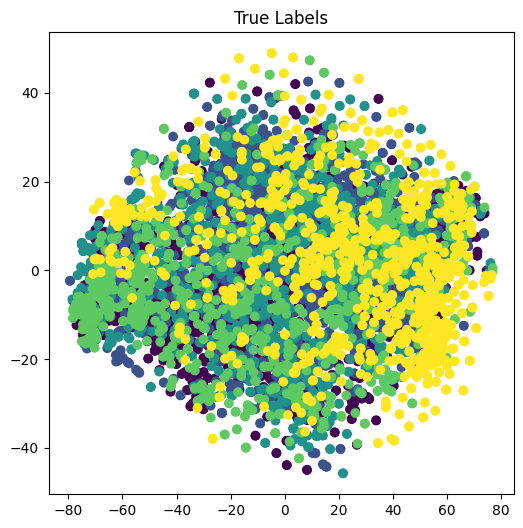

In [5]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
train_images_tsne = tsne.fit_transform(train_images)

# Plot the true labels
plt.figure(figsize=(6, 6))
plt.scatter(train_images_tsne[:, 0], train_images_tsne[:, 1], c=train_labels)
plt.title('True Labels')
plt.show()

In [7]:
import pandas as pd

# Tạo DataFrame từ tọa độ 2D và nhãn
data = {
    'tsne-2d-one': train_images_tsne[:, 0],
    'tsne-2d-two': train_images_tsne[:, 1],
    'label': train_labels
}
df = pd.DataFrame(data)

# Lưu DataFrame vào file CSV
df.to_csv('data_tsne.csv', index=False)

In [61]:
# Define the clustering algorithms
algorithms = [
    ('KMeans', KMeans(n_clusters=5, random_state=0)),
    ('AgglomerativeClustering', AgglomerativeClustering(n_clusters=5)),
    ('GaussianMixture', GaussianMixture(n_components=5, random_state=0)),
    ('DBSCAN', DBSCAN(eps=10 ** (-10), min_samples=500)),
    ('SpectralClustering', SpectralClustering(n_clusters=5, random_state=0, gamma=100000, n_neighbors=2000))
]

KMeans clustering results saved!
AgglomerativeClustering clustering results saved!
GaussianMixture clustering results saved!
DBSCAN clustering results saved!


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


SpectralClustering clustering results saved!


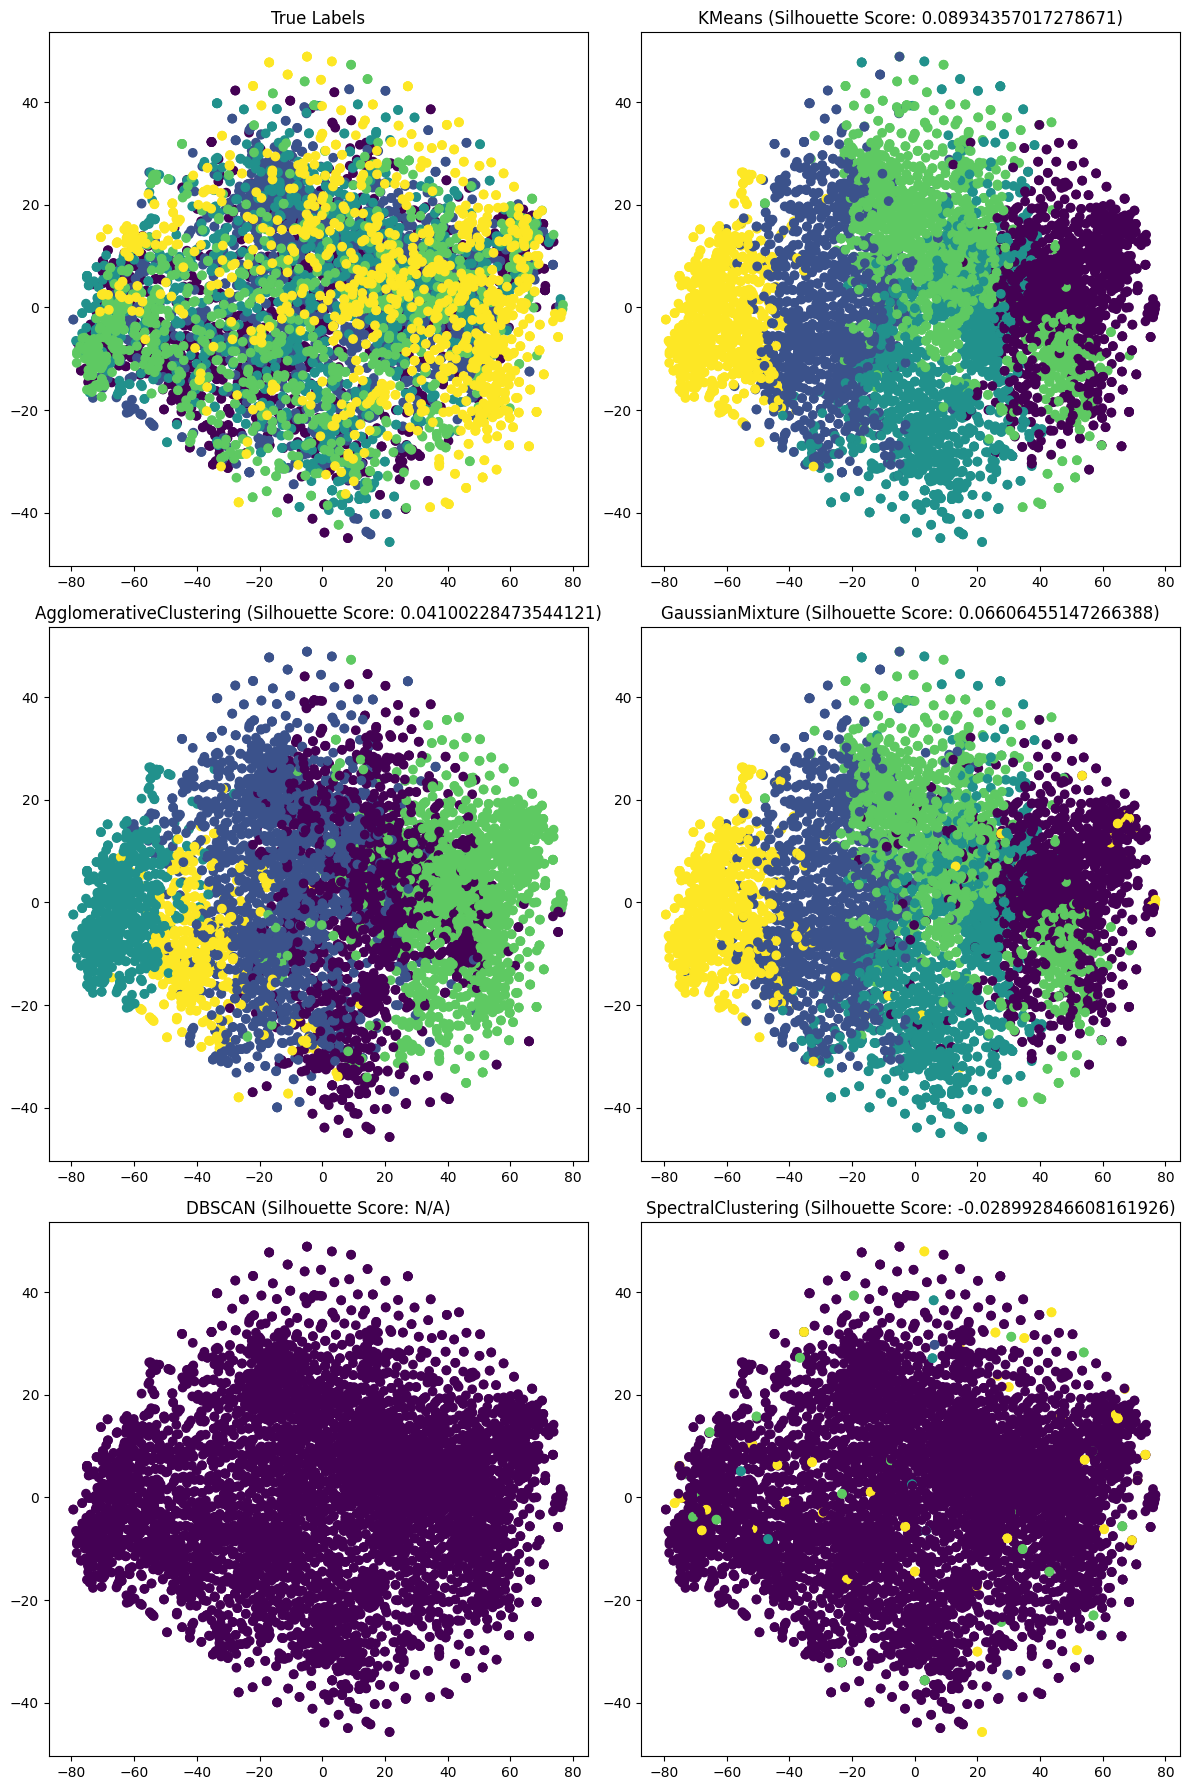

In [62]:
fig, axs = plt.subplots(3, 2, figsize=(12, 18))

# Plot the true labels
axs[0, 0].scatter(train_images_tsne[:, 0], train_images_tsne[:, 1], c=train_labels)
axs[0, 0].set_title('True Labels')

# Apply each clustering algorithm and plot the results
for i, (name, algorithm) in enumerate(algorithms, start=1):
    # Perform clustering
    labels = algorithm.fit_predict(train_images)

    # Evaluate the clustering
    score = silhouette_score(train_images, labels) if len(np.unique(labels)) > 1 else 'N/A'

    # Plot the results
    axs[i // 2, i % 2].scatter(train_images_tsne[:, 0], train_images_tsne[:, 1], c=labels)
    axs[i // 2, i % 2].set_title(f'{name} (Silhouette Score: {score})')

    # Save the results
    results = pd.DataFrame({
        'tsne-2d-one': train_images_tsne[:, 0],
        'tsne-2d-two': train_images_tsne[:, 1],
        'cluster': labels
    })
    results.to_csv(f'{name}_clustering_results.csv', index=False)
    print(f'{name} clustering results saved!')

plt.tight_layout()
plt.show()

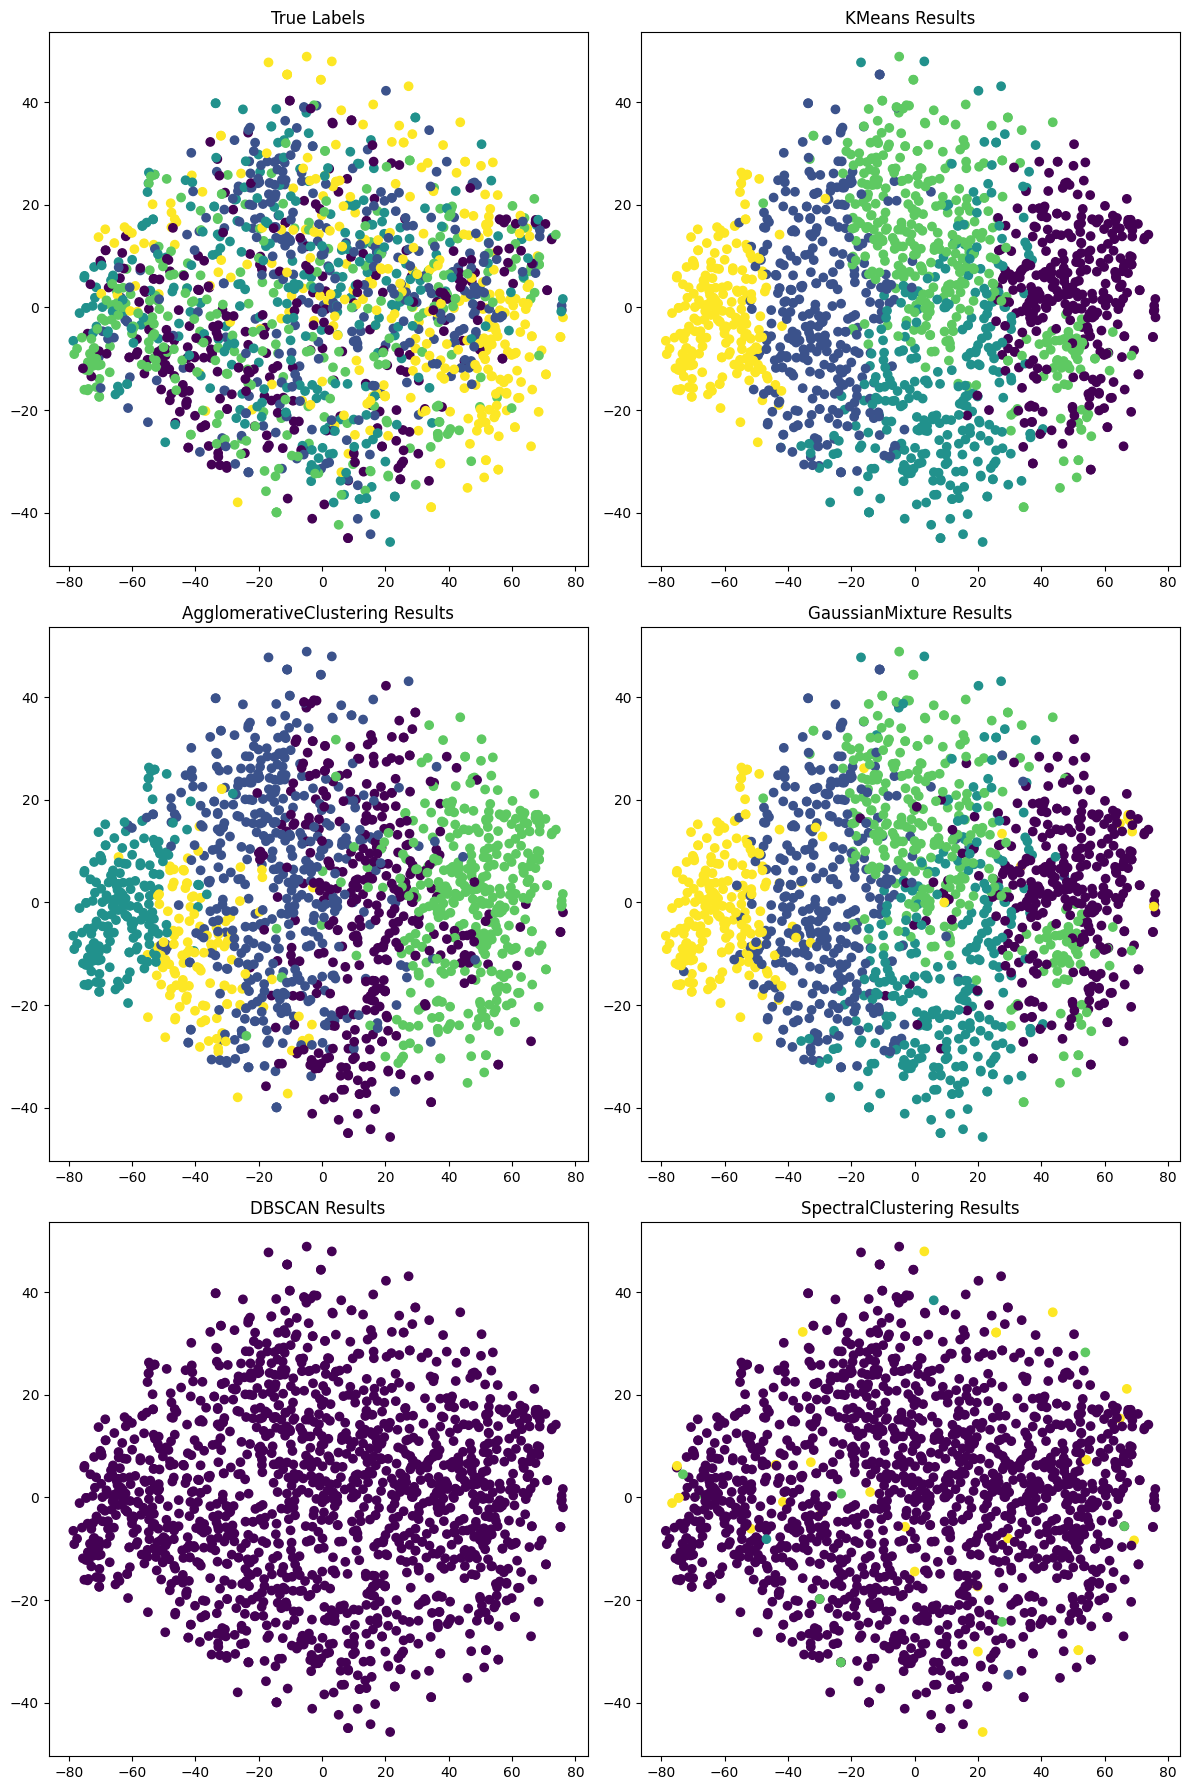

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the clustering results from the CSV files
algorithm_names = ['True Label', 'KMeans', 'AgglomerativeClustering', 'GaussianMixture', 'DBSCAN', 'SpectralClustering']
dfs = []
df = pd.read_csv('data_tsne.csv')
dfs.append(df)

for algorithm_name in algorithm_names[1:]:
    df = pd.read_csv(f'{algorithm_name}_clustering_results.csv')
    dfs.append(df)

# Select 500 random data points
selected_indices = np.random.choice(len(dfs[0]), size=1500, replace=False)

# Get the selected data points for each algorithm
selected_data_points = []
for df in dfs:
    selected_data_points.append(df.iloc[selected_indices])

# Plot the results
fig, axs = plt.subplots(3, 2, figsize=(12, 18))

for i, (algorithm_name, data_points) in enumerate(zip(algorithm_names, selected_data_points), start=0):
    # Plot the results
    if algorithm_name == 'True Label':
        axs[i // 2, i % 2].scatter(data_points['tsne-2d-one'], data_points['tsne-2d-two'], c=data_points['label'])
        axs[i // 2, i % 2].set_title('True Labels')
    else:
        axs[i // 2, i % 2].scatter(data_points['tsne-2d-one'], data_points['tsne-2d-two'], c=data_points['cluster'])
        axs[i // 2, i % 2].set_title(f'{algorithm_name} Results')

plt.tight_layout()
plt.show()